In [42]:
!pip install joblib fastapi uvicorn scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import joblib

In [60]:
df = pd.read_csv(r"C:\\Users\\pavit\\Downloads\\credit_card_fraud_10k.csv")
df.head()

,transaction_id,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
0,1,84.47,22,Electronics,0,0,66,3,40,0
1,2,541.82,3,Travel,1,0,87,1,64,0
2,3,237.01,17,Grocery,0,0,49,1,61,0
3,4,164.33,4,Grocery,0,1,72,3,34,0
4,5,30.53,15,Food,0,0,79,0,44,0


In [61]:
df.isnull().sum()

transaction_id         0
amount                 0
transaction_hour       0
merchant_category      0
foreign_transaction    0
location_mismatch      0
device_trust_score     0
velocity_last_24h      0
cardholder_age         0
is_fraud               0
dtype: int64

In [62]:
print(df.duplicated().sum())

0


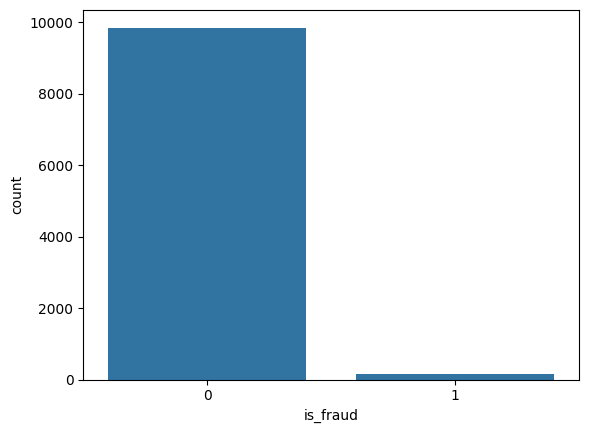

In [63]:
sns.countplot(x = 'is_fraud', data=df)
plt.show()

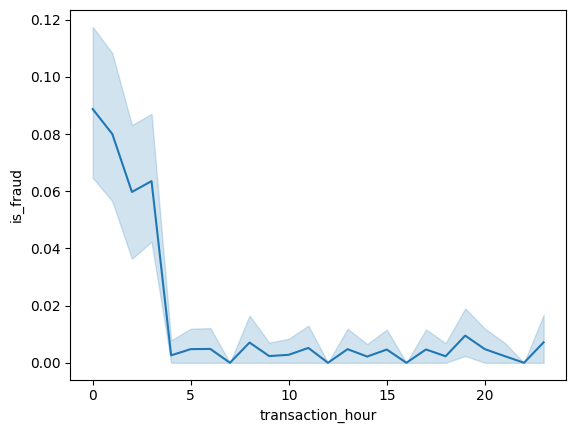

In [64]:
sns.lineplot(x='transaction_hour', y='is_fraud', data=df)
plt.show()

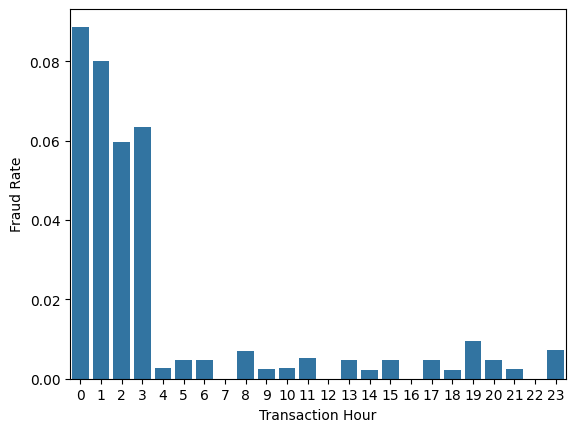

In [65]:
fraud_rate = (
    df.groupby('transaction_hour')['is_fraud']
      .mean()
      .reset_index()
)

plt.figure()
sns.barplot(
    data=fraud_rate,
    x='transaction_hour',
    y='is_fraud'
)
plt.ylabel("Fraud Rate")
plt.xlabel("Transaction Hour")
plt.show()


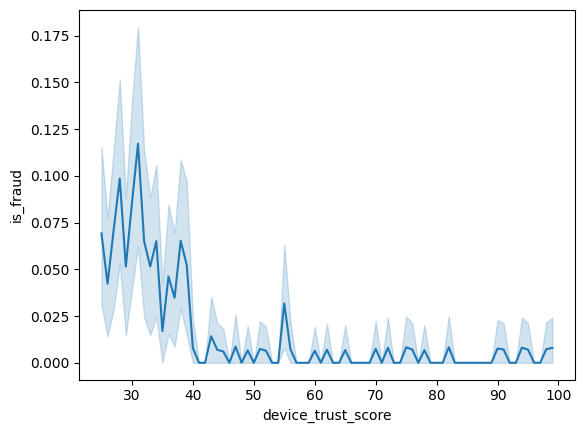

In [66]:
sns.lineplot(x = 'device_trust_score', y='is_fraud', data=df)
plt.show()

In [67]:
cond1 = ((df['device_trust_score'] < 50) & (df['is_fraud'] == 1)).sum()
cond2 = (df['is_fraud'] == 1).sum()
print(cond1 / cond2)

0.8543046357615894


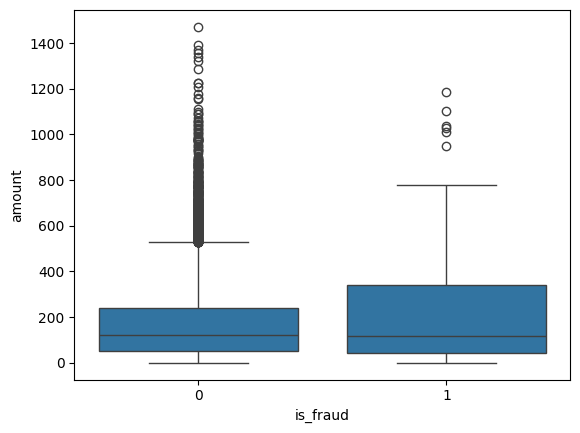

In [68]:
plt.figure()
sns.boxplot(x='is_fraud', y='amount', data=df)
plt.show()

In [69]:
print(f"Amount greater than 500 bucks and is fraud : {((df['amount'] >= 500) & (df['is_fraud'] == 1)).sum()}")
print(f"Average transaction amount : {df['amount'].mean()}")

Amount greater than 500 bucks and is fraud : 16
Average transaction amount : 175.94984899999997


In [70]:
print(f"{((df['foreign_transaction'] == 1) & (df['location_mismatch'] == 1) & (df['is_fraud'] == 1)).sum()}")

29


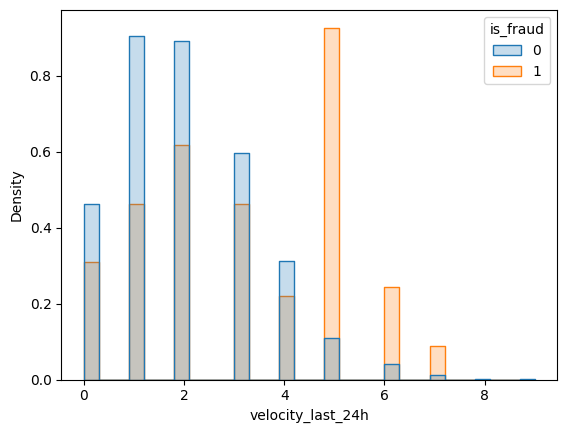

In [71]:
plt.figure()
sns.histplot(
    data=df,
    x='velocity_last_24h',
    hue='is_fraud',
    bins=30,
    element='step',
    stat='density',
    common_norm=False
)
plt.show()

Velocity_last_24h which represents number of transactions attempted in the last 24hours. One of the high ROI feature for is_fraud

In [72]:
global_mean = df["is_fraud"].mean()

fraud_rate_map = (
    df.groupby("merchant_category")["is_fraud"]
      .mean()
      .to_dict()
)

df["merchant_category_fraud_rate"] = (
    df["merchant_category"]
    .map(fraud_rate_map)
    .fillna(global_mean)
)


In [73]:
freq_map = (
    df["merchant_category"]
    .value_counts()
    .to_dict()
)

df["merchant_category_frequency"] = (
    df["merchant_category"]
    .map(freq_map)
    .fillna(0)
)


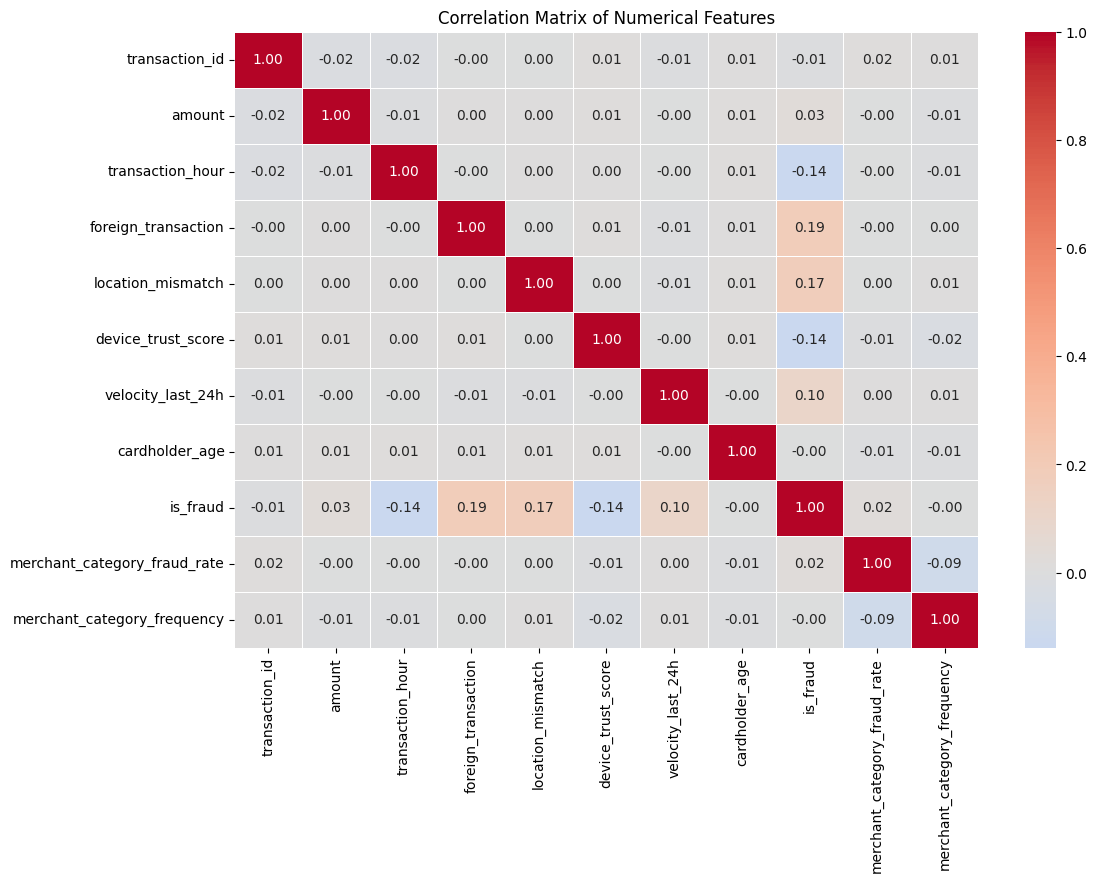

In [74]:
num_df = df.select_dtypes(include=['int64', 'float64'])
corr = num_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [75]:
df.head()

,transaction_id,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud,merchant_category_fraud_rate,merchant_category_frequency
0,1,84.47,22,Electronics,0,0,66,3,40,0,0.012480,1923
1,2,541.82,3,Travel,1,0,87,1,64,0,0.014573,1990
2,3,237.01,17,Grocery,0,0,49,1,61,0,0.020062,1944
3,4,164.33,4,Grocery,0,1,72,3,34,0,0.020062,1944
4,5,30.53,15,Food,0,0,79,0,44,0,0.016722,2093


In [76]:
df = df.drop(columns=['merchant_category'])
df.head()

,transaction_id,amount,transaction_hour,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud,merchant_category_fraud_rate,merchant_category_frequency
0,1,84.47,22,0,0,66,3,40,0,0.012480,1923
1,2,541.82,3,1,0,87,1,64,0,0.014573,1990
2,3,237.01,17,0,0,49,1,61,0,0.020062,1944
3,4,164.33,4,0,1,72,3,34,0,0.020062,1944
4,5,30.53,15,0,0,79,0,44,0,0.016722,2093


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
X = df.drop(columns=['is_fraud', 'transaction_id'])
y = df['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 40)
rf = RandomForestClassifier(
    n_estimators = 200,
    max_depth = None,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=40,
    n_jobs= -1
)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,10
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [78]:
y_prob = rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc  = average_precision_score(y_test, y_prob)

print("ROC-AUC:", roc_auc)
print("PR-AUC :", pr_auc)

ROC-AUC: 0.9981049069373942
PR-AUC : 0.9379560290621352


In [79]:
custom_txn = {
    "amount": 1200.0,
    "transaction_hour": 2,
    "foreign_transaction": 1,
    "location_mismatch": 1,
    "device_trust_score": 30,
    "velocity_last_24h": 6,
    "cardholder_age": 28,
    "merchant_category_fraud_rate": 0.18,
    "merchant_category_frequency": 12
}
custom_df = pd.DataFrame([custom_txn])
risk_score = rf.predict_proba(custom_df)[:, 1][0]
print(risk_score)

0.9352894037197926


In [80]:
joblib.dump(rf, "random_forest_model.pkl")

['random_forest_model.pkl']